In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
Transform = transform.Compose([transform.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist/',train=True,download=True,transform=Transform)
testset = torchvision.datasets.MNIST(root='./data_mnist/',train=False,download=True,transform=Transform)

trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
testloader = DataLoader(testset,batch_size=64,shuffle=True)

In [4]:
class my_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(256,128)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(128,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x

def Train_(model,Epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    w = pd.DataFrame()
    for epoch in range(1,Epoch+1):
        for i, (input, label) in enumerate(trainloader):
            input, label = input.to(device), label.to(device)
            y_hat = model(input.view(-1,784)).to(device)
            loss = model.cross_ent(y_hat,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if epoch % 3 == 0:
            d = pd.DataFrame()
            for n,p in model.named_parameters():
                if 'weight' in n:
                    W_ = nn.utils.parameters_to_vector(p).detach().cpu().numpy()
                    d = pd.concat([d,pd.DataFrame(W_).T],axis=1)
            w = pd.concat([w,d],axis=0)
    return w

100%|██████████| 8/8 [32:04<00:00, 240.58s/it]


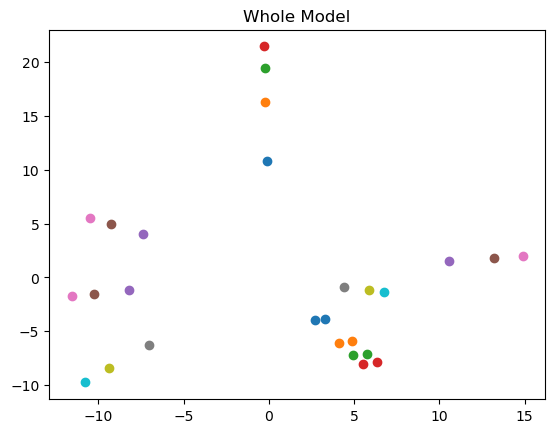

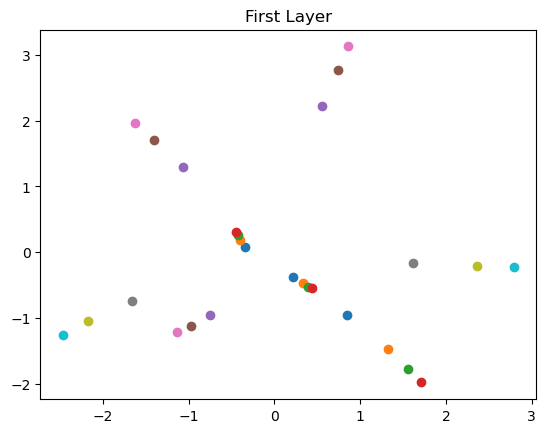

In [5]:
if __name__=='__main__':
    Epoch = 30
    pca = PCA(n_components=2)
    whole_weights = pd.DataFrame()
    for i in tqdm(range(8)):
        model = my_cnn().to(device)
        w = Train_(model,Epoch)
        whole_weights = pd.concat([whole_weights,w],axis=0)
    
    # plots
    w_ = np.array(whole_weights)
    w__ = pca.fit_transform(w_)
    _w_ = pd.DataFrame(w__, columns=['x','y'])
    W = _w_.iloc[::3,:]
    for i in range(len(W)):
        plt.scatter(W['x'][i*3], W['y'][i*3])
    plt.title('Whole Model')
    plt.show()
    
    L1 = whole_weights.iloc[:,:7840]
    L = np.array(L1)
    L_ = pca.fit_transform(L)
    _L_ = pd.DataFrame(L_, columns=['x','y'])
    WL1 = _L_.iloc[::3,:]
    for i in range(len(WL1)):
        plt.scatter(WL1['x'][i*3], WL1['y'][i*3])
    plt.title('First Layer')
    plt.show()